In [222]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [226]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [223]:
data_loc = "D:/Beam Characterization/2019_5_3/"
fname = "2019_05_03.hdf"

In [224]:
with h5py.File(data_loc+fname, 'r') as f:
    for name in f.keys():
        print(name)

1556908328 scanning
1556908481 scanning
1556908979 new_spot
1556909087 new_spot
1556909311 scanning
1556919514 new spot
1556919722 scanning


275848999.0


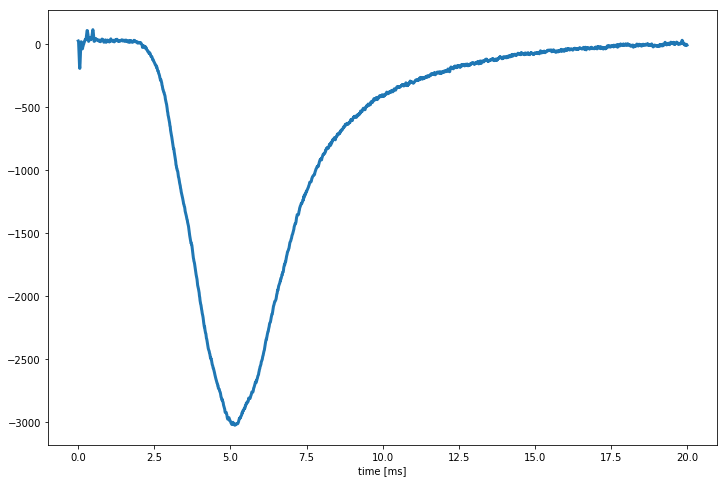

In [243]:
run_name = "1556919514 new spot"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value
        
x = np.linspace(0,2000,2000)/100

data_f = np.mean([fast_daq['PXIe5171_{0}'.format(idx)][:,2] for idx in range(len(fast_daq)-5,len(fast_daq))], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_f-data_f[-100:].mean(), lw = 3)

ax.set_xlabel("time [ms]")
print(wavemeter[-1][-1]*1e6)

In [241]:
wavemeter[-1][-1]

275.848999

In [233]:
len(data_f)

10

In [188]:
run_name = "1556909311 scanning"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

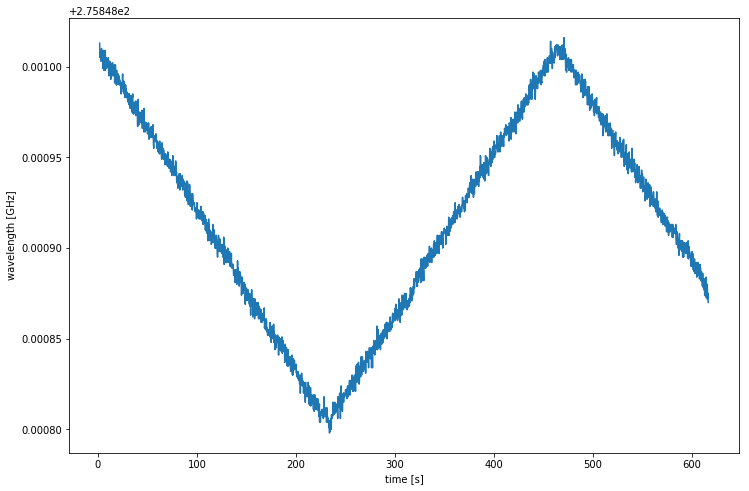

In [189]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

301


Text(0.5, 0, 'time [ms]')

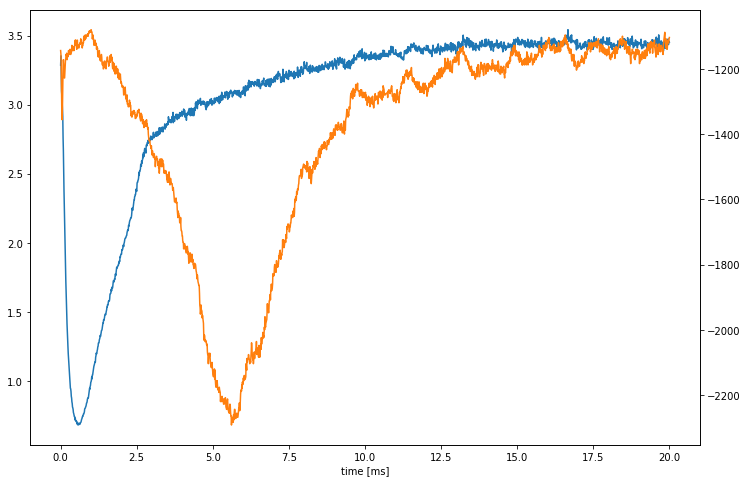

In [191]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

idx = 300
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,2000,2000)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')

ax.set_xlabel("time [ms]")

In [192]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[-200:], dx=dx)
        signal = np.trapz(data_f[100:-200], dx=dx)-17/2*background
        integrals.append((idx,-signal,-background))
integrals = np.array(integrals)

100%|███████████████████████████████████████████████████████████████████████████| 1230/1230 [00:00<00:00, 16183.15it/s]


In [193]:
rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

In [194]:
start, stop = 0, -1

wavelength_amp = []
for val in integrals[start:stop]:
    idx_int = val[0]
    wavelength_amp.append((dict(wavelength_values)[idx_int]*1e6, val[1], idx_int))
wavelength_amp = np.array(wavelength_amp)[:-200]

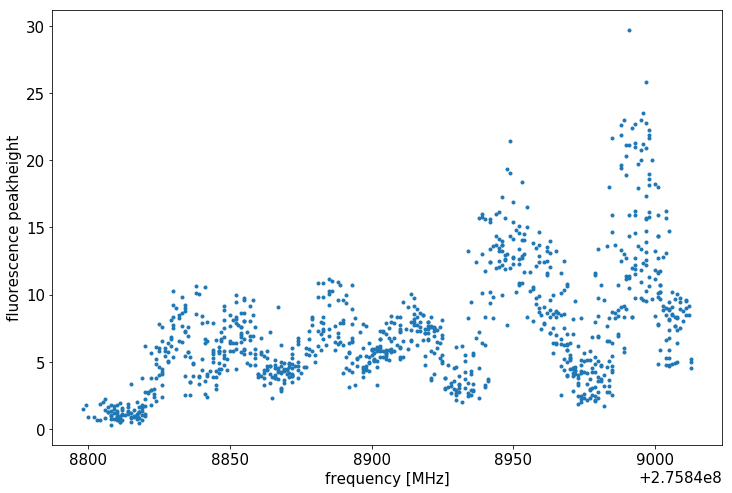

In [195]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavelength_amp[:,0]*conversion, wavelength_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

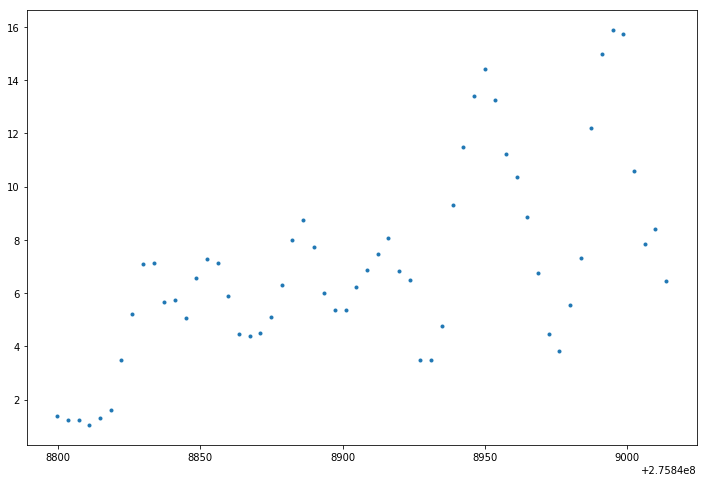

In [196]:
fit_array = wavelength_amp[wavelength_amp[:,0].argsort()]
fit_array[:,0]

df = 15/4
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means, '.');

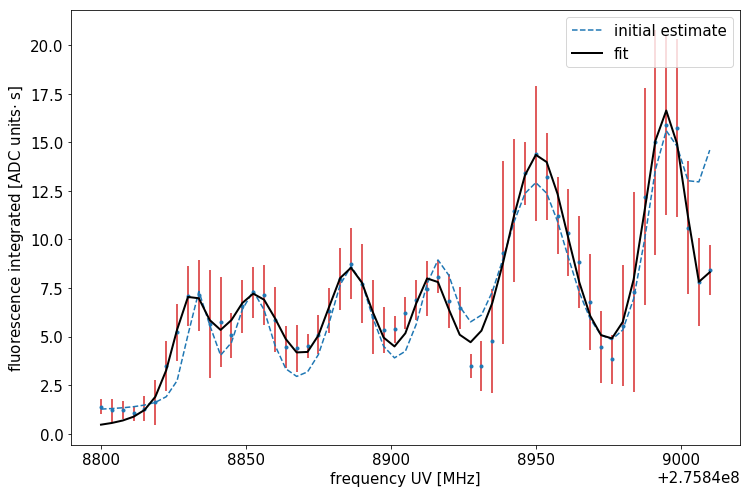

In [197]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks

names = ['P_{0}'.format(idx) for idx in range(7)]

idx_offset = 0

minimum_peak_height = 6.5
distance = 15/np.diff(midpoint)[0]
width = 5/np.diff(midpoint)[0]
peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)

peaks = list(peaks)
if (peaks[0][-1] <= len(bin_means)-1-distance) and (bin_means[len(bin_means)-int(1*distance):].max() >= minimum_peak_height):
    peaks[0] = np.append(peaks[0], len(midpoint)-1)
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'], peaks[1]['peak_heights'][-1])
    peaks[1]['widths'] = np.append(peaks[1]['widths'], peaks[1]['widths'][-1])
    
peaks = list(peaks)
if (peaks[0][0] <= 1*distance) and (bin_means[:int(1*distance)].max() >= minimum_peak_height):
    peaks[0] = np.append(0, peaks[0])
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'][-1], peaks[1]['peak_heights'])
    peaks[1]['widths'] = np.append(peaks[1]['widths'][-1], peaks[1]['widths'])
    
def offset(x,offset):
    return np.ones(len(x))*offset


if len(names) == 0:
    name = 'P'
    
fit_models = []
p0 = [(float(bin_means.min()))]
for idx, p in enumerate(peaks[0]):
    if len(names) == 0:
        fit_models.append(models.VoigtModel(prefix=name+'_{}_'.format(idx+idx_offset)))
    else:
        fit_models.append(models.VoigtModel(prefix=names[idx]+'_'))
    sigma = np.diff(midpoint)[0]*peaks[1]['widths'][idx]/(2*1.6)
    center = midpoint[p]
    amplitude = peaks[1]['peak_heights'][idx]*np.sqrt(2*np.pi*sigma**2)*1.5
    p0.append((sigma, center, amplitude))
    
model_bg = Model(offset)
model = model_bg
for m in fit_models:
    model += m
    
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 30)
    elif 'center' in par:
        params[par].set(min = midpoint.min(), max = midpoint.max())
        
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x, result.init_fit, '--', label = 'initial estimate')
ax.plot(x, result.best_fit, 'k-', lw = 2, label = 'fit')
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

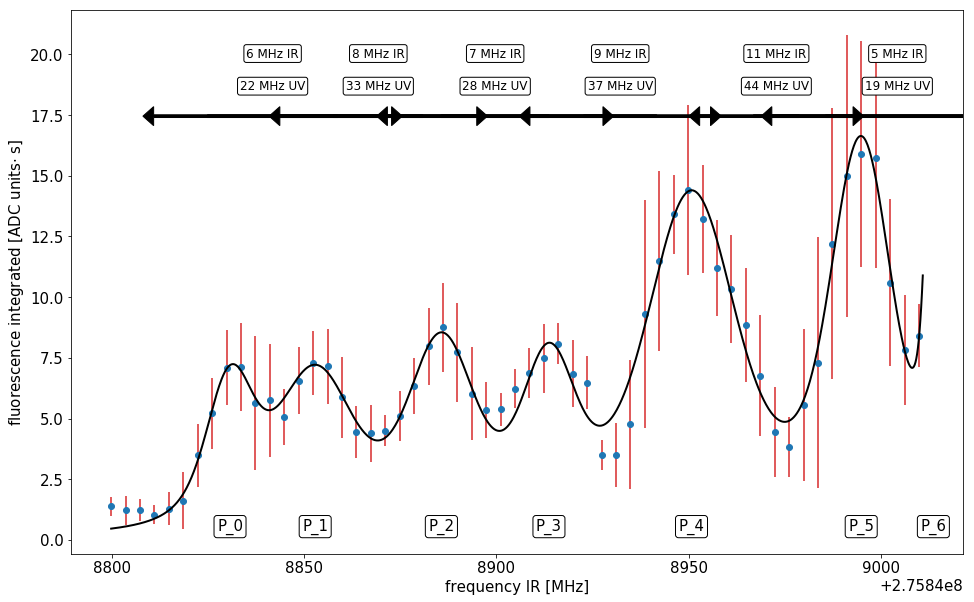

In [198]:
fit_x = np.linspace(x.min(), x.max()+1, 1001)
x_offset = 0
plocs = []
for par in result.best_values:
    if 'center' in par:
        plocs.append(result.best_values[par])
plocs.sort()

fig, ax = plt.subplots(figsize = (16,10))
ax.errorbar(x+x_offset,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1, ms = 12)
ax.plot(fit_x+x_offset, model.eval(result.params, x=fit_x), 'k-', lw = 2)

ylim = ax.get_ylim()
xlim = ax.get_xlim()
height_arrow = 0.8*ylim[1]
height_dist = 0.85*ylim[1]
height_peakl = 0.05*np.diff(ylim)+ylim[0]
bbox = dict(boxstyle="round", fc="w", ec="k", pad=0.2)
labels = [f.prefix.strip('_') for f in fit_models]
for ploc, dist, lab in zip(plocs, np.diff(plocs), labels):
    ploc += x_offset
    ax.text((ploc+dist/2),height_dist,'{0:.0f} MHz UV'.format(dist), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc+dist/2),height_dist+0.06*np.diff(ylim),'{0:.0f} MHz IR'.format(dist/4), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc),height_peakl,lab, horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)

    ax.arrow((ploc+28),height_arrow,(dist-28*2.5),0, shape = 'full', head_width=np.diff(ylim)*0.035, head_length=np.diff(xlim)*0.012, fc='k', ec='k', width = np.diff(ylim)*0.005)
    ax.arrow((ploc+(dist-28)),height_arrow,(-(dist-28*2.5)),0, shape = 'full', head_width=np.diff(ylim)*0.035, head_length=np.diff(xlim)*0.012, fc='k', ec='k', width = np.diff(ylim)*0.005)

ax.text((plocs[-1]+x_offset),height_peakl,labels[-1], horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)
    
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

In [199]:
for key in result.best_values:
    if 'center' in key:
        print("{0:15} : {1:.0f} MHz".format(key, result.best_values[key]))

P_6_center      : 275849014 MHz
P_5_center      : 275848995 MHz
P_4_center      : 275848951 MHz
P_3_center      : 275848914 MHz
P_2_center      : 275848886 MHz
P_1_center      : 275848853 MHz
P_0_center      : 275848831 MHz


In [200]:
print(result.fit_report())

[[Model]]
    (((((((Model(offset) + Model(voigt, prefix='P_0_')) + Model(voigt, prefix='P_1_')) + Model(voigt, prefix='P_2_')) + Model(voigt, prefix='P_3_')) + Model(voigt, prefix='P_4_')) + Model(voigt, prefix='P_5_')) + Model(voigt, prefix='P_6_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 376
    # data points      = 57
    # variables        = 22
    chi-square         = 128.031112
    reduced chi-square = 3.65803177
    Akaike info crit   = 90.1256557
    Bayesian info crit = 135.072784
[[Variables]]
    offset:         8.1828e-07 (init = 1.045843)
    P_0_sigma:      4.18558146 (init = 2.605345)
    P_0_center:     2.7585e+08 (init = 2.758488e+08)
    P_0_amplitude:  118.515599 (init = 69.77375)
    P_1_sigma:      6.59064346 (init = 4.118646)
    P_1_center:     2.7585e+08 (init = 2.758489e+08)
    P_1_amplitude:  197.831654 (init = 112.7418)
    P_2_sigma:      5.79119491 (init = 4.806678)
    P_2_center:     2.7585e+08 (init = 2.758489e+08)


In [246]:
run_name = "1556919722 scanning"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

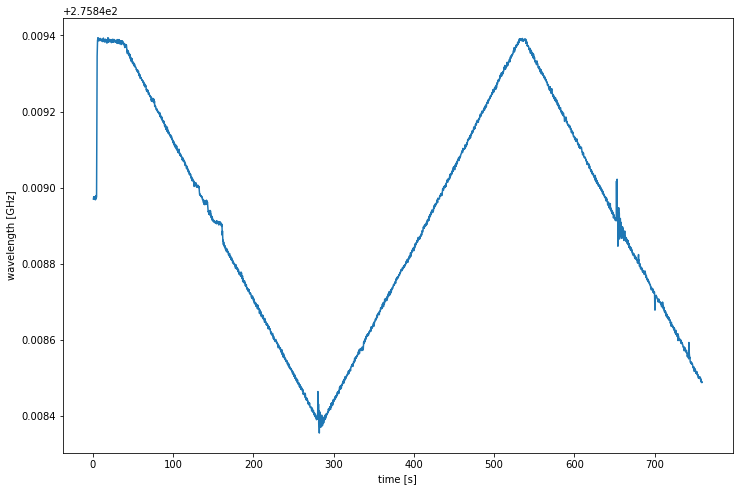

In [247]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

In [248]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

301


Text(0.5, 0, 'time [ms]')

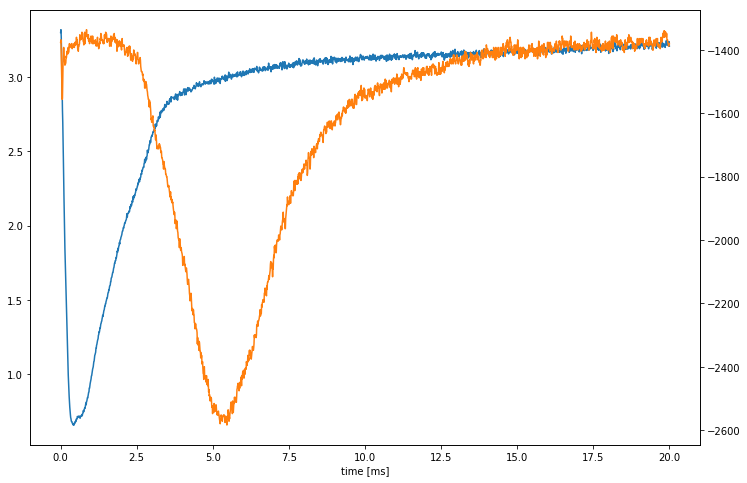

In [249]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

idx = 300
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,2000,2000)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')

ax.set_xlabel("time [ms]")

In [250]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[-200:], dx=dx)
        signal = np.trapz(data_f[100:-200], dx=dx)-17/2*background
        integrals.append((idx,-signal,-background))
integrals = np.array(integrals)

100%|███████████████████████████████████████████████████████████████████████████| 1517/1517 [00:00<00:00, 17639.44it/s]


In [251]:
rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

In [252]:
start, stop = 0, -1

wavelength_amp = []
for val in integrals[start:stop]:
    idx_int = val[0]
    wavelength_amp.append((dict(wavelength_values)[idx_int]*1e6, val[1], idx_int))
wavelength_amp = np.array(wavelength_amp)[:-200]

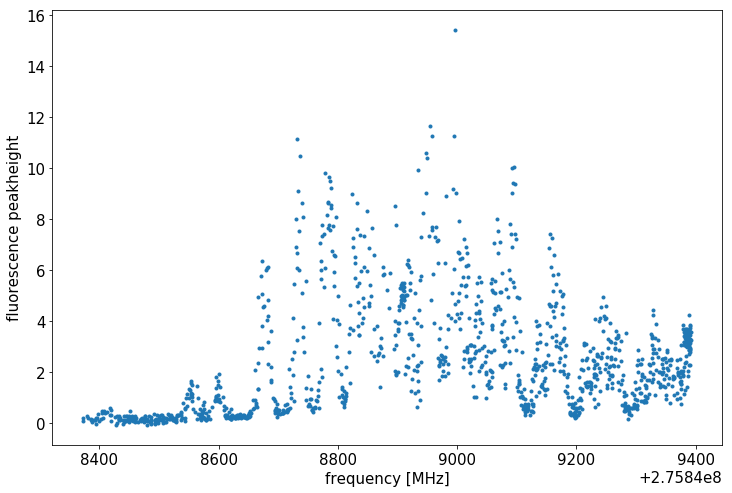

In [253]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavelength_amp[:,0]*conversion, wavelength_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


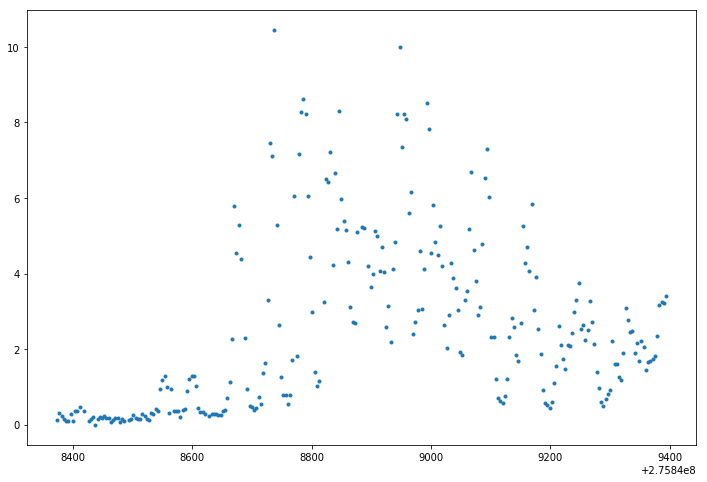

In [254]:
fit_array = wavelength_amp[wavelength_amp[:,0].argsort()]
fit_array[:,0]

df = 15/4
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means, '.');

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


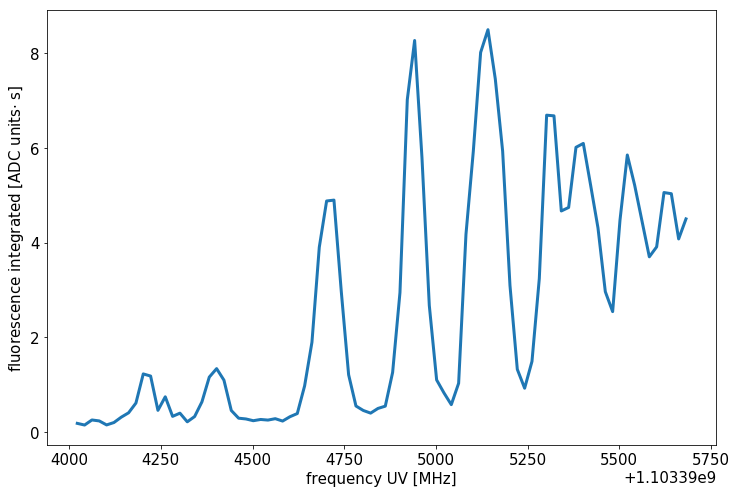

In [269]:
fit_array = wavelength_amp[wavelength_amp[:,0].argsort()]
fit_array = fit_array[(fit_array[:,0] > 2.7584e8+8500) & (fit_array[:,0] < 2.7584e8+8921)]

df = 5
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

bin_means = bin_means[midpoint <= 2.7584e8+9000]
bin_errors = bin_errors[midpoint <= 2.7584e8+9000]
midpoint = midpoint[midpoint <= 2.7584e8+9000]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint*4, bin_means, lw = 3);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);
fig.savefig('multi_hole_snorkel.png')

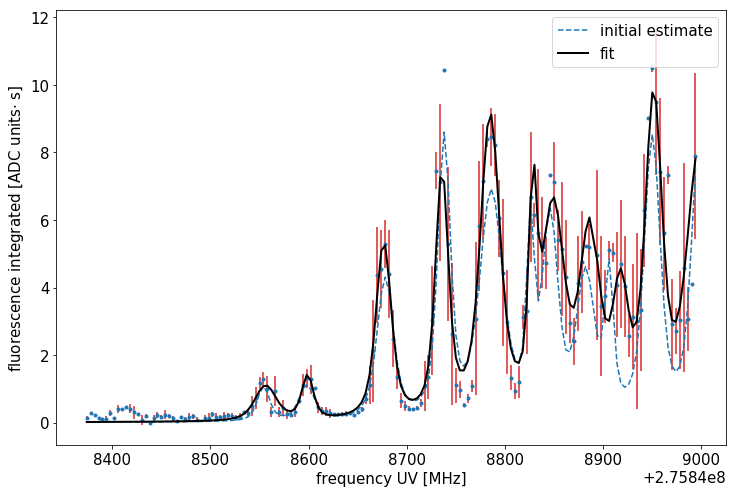

In [221]:
from lmfit import models
from lmfit import Model
from scipy.signal import find_peaks


idx_offset = 0

minimum_peak_height = 1
distance = 15/np.diff(midpoint)[0]
width = 5/np.diff(midpoint)[0]
peaks = find_peaks(bin_means, height = minimum_peak_height, threshold = None, distance = distance, width = width)

peaks = list(peaks)
if (peaks[0][-1] <= len(bin_means)-1-distance) and (bin_means[len(bin_means)-int(1*distance):].max() >= minimum_peak_height):
    peaks[0] = np.append(peaks[0], len(midpoint)-1)
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'], peaks[1]['peak_heights'][-1])
    peaks[1]['widths'] = np.append(peaks[1]['widths'], peaks[1]['widths'][-1])
    
peaks = list(peaks)
if (peaks[0][0] <= 1*distance) and (bin_means[:int(1*distance)].max() >= minimum_peak_height):
    peaks[0] = np.append(0, peaks[0])
    peaks[1]['peak_heights'] = np.append(peaks[1]['peak_heights'][-1], peaks[1]['peak_heights'])
    peaks[1]['widths'] = np.append(peaks[1]['widths'][-1], peaks[1]['widths'])
    
def offset(x,offset):
    return np.ones(len(x))*offset

names = ['P_{0}'.format(idx) for idx in range(len(peaks[0]))]

if len(names) == 0:
    name = 'P'
    
fit_models = []
p0 = [(float(bin_means.min()))]
for idx, p in enumerate(peaks[0]):
    if len(names) == 0:
        fit_models.append(models.VoigtModel(prefix=name+'_{}_'.format(idx+idx_offset)))
    else:
        fit_models.append(models.VoigtModel(prefix=names[idx]+'_'))
    sigma = np.diff(midpoint)[0]*peaks[1]['widths'][idx]/(2*1.6)
    center = midpoint[p]
    amplitude = peaks[1]['peak_heights'][idx]*np.sqrt(2*np.pi*sigma**2)*1.5
    p0.append((sigma, center, amplitude))
    
model_bg = Model(offset)
model = model_bg
for m in fit_models:
    model += m
    
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 30)
    elif 'center' in par:
        params[par].set(min = midpoint.min(), max = midpoint.max())
        
offset = 1
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
ax.plot(x, result.init_fit, '--', label = 'initial estimate')
ax.plot(x, result.best_fit, 'k-', lw = 2, label = 'fit')
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

In [292]:
def change_fontsize(ax, fontsize):
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)

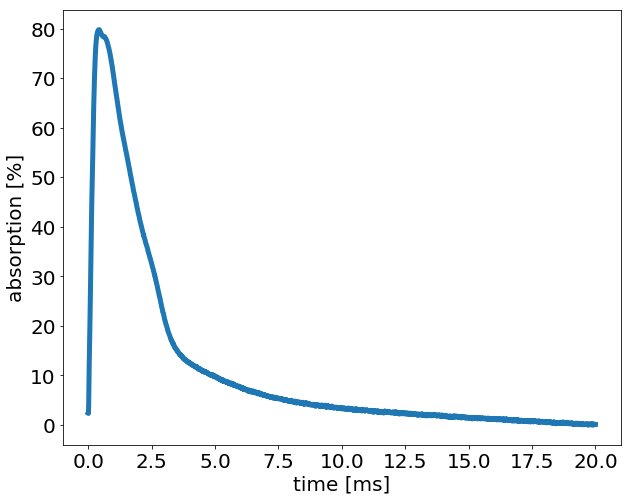

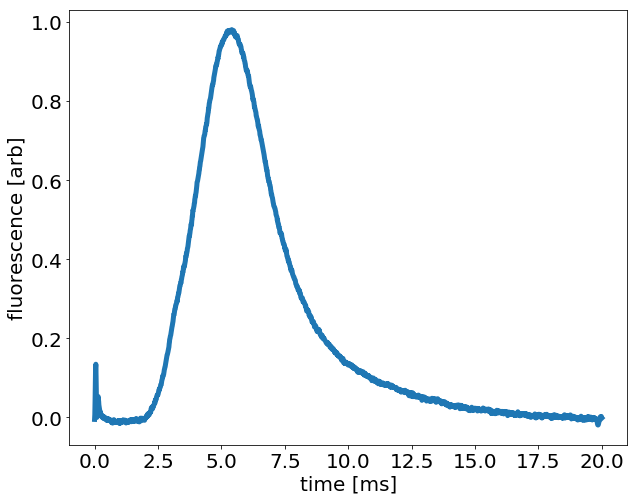

In [297]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]


x = np.linspace(0,2000,2000)/100

a = np.zeros(2000)
f = np.zeros(2000)
for i in range(300,320):
    idx = yag_fire[i]
    a += fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
    f += fast_daq['PXIe5171_{0}'.format(idx)][:,2]

a /= 20
f /= 20

fig, ax = plt.subplots(figsize = (10,8))

ax.plot(x, 100*(1-a/a.max()), lw = 5)
ax.set_xlabel('time [ms]')
ax.set_ylabel('absorption [%]')
change_fontsize(ax, 20)

fig.savefig('abs_presentation.png')

fig, ax = plt.subplots(figsize = (10,8))

ax.plot(x, -(f-f[-10:].mean())/f.ptp(), lw = 5)
ax.set_xlabel('time [ms]')
ax.set_ylabel('fluorescence [arb]')
change_fontsize(ax, 20)

fig.savefig('lif_presentation.png')

301


Text(0.5, 0, 'time [ms]')

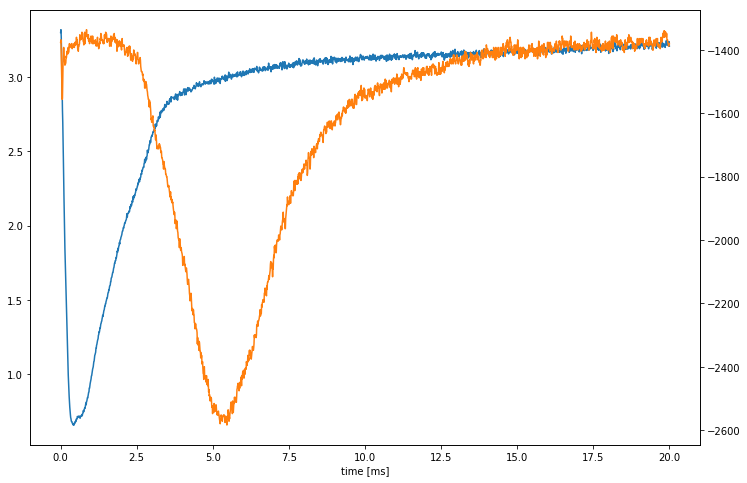

In [271]:
rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

idx = 300
idx = yag_fire[idx]
print(idx)


data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')

ax.set_xlabel("time [ms]")